# Haiku and `jax2tf`

`jax2tf` is an advanced JAX feature supporting staging JAX programs out as TensorFlow graphs.

This is a useful feature if you want to integrate with an existing TensorFlow codebase or tool. In this tutorial we will demonstrate defining a simple model in Haiku, converting it to TensorFlow as a `tf.Module` and then training it.

We'll then save the model as a [TensorFlow SavedModel](https://www.tensorflow.org/guide/saved_model) so it can be used later in other TensorFlow programs.

In [1]:
!pip install dm-tree dm-sonnet tensorflow tensorflow_datasets ipywidgets matplotlib >/dev/null

In [3]:
!pip install -U dm-haiku

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.7/371.7 kB 2.9 MB/s eta 0:00:00


In [4]:
import haiku as hk
import jax
import jax.numpy as jnp
from jax.experimental import jax2tf
import sonnet as snt
import tensorflow as tf
import tree

## Define your model in JAX

First things first, we need to define our model using Haiku and JAX. For MNIST we can use a trivial model like an MLP.

We initialize the model using JAX and get initial parameter values. If you wanted you could additionally go on to train your model using JAX, but in this example we will do that in TensorFlow.

In [5]:
def f(x):
  net = hk.nets.MLP([300, 100, 10])
  return net(x)

f = hk.transform(f)

rng = jax.random.PRNGKey(42)
x = jnp.ones([1, 28 * 28 * 1])
params = f.init(rng, x)

## Convert to TensorFlow

TensorFlow ships with a module abstraction that supports common tasks like collecting model parameters.

Sonnet is a library of `tf.Module` subclasses including common NN layers, optimizers and some metrics. Sonnet is a sister library to Haiku developed by the same team.

We will use Sonnet's module class for some nice `name_scope`-ing and later we will use the Adam optimizer implemented in Sonnet as well as some utility functions.

In [6]:
def create_variable(path, value):
  name = '/'.join(map(str, path)).replace('~', '_')
  return tf.Variable(value, name=name)

class JaxModule(snt.Module):
  def __init__(self, params, apply_fn, name=None):
    super().__init__(name=name)
    self._params = tree.map_structure_with_path(create_variable, params)
    self._apply = jax2tf.convert(lambda p, x: apply_fn(p, None, x))
    self._apply = tf.autograph.experimental.do_not_convert(self._apply)

  def __call__(self, inputs):
    return self._apply(self._params, inputs)

net = JaxModule(params, f.apply)
[v.name for v in net.trainable_variables]

['jax_module/mlp/_/linear_0/b:0',
 'jax_module/mlp/_/linear_0/w:0',
 'jax_module/mlp/_/linear_1/b:0',
 'jax_module/mlp/_/linear_1/w:0',
 'jax_module/mlp/_/linear_2/b:0',
 'jax_module/mlp/_/linear_2/w:0']

## Train using TensorFlow

TensorFlow datasets is a great library with lots of common datasets that you might want to do research with. Here we will use it to load the MNIST handwritten digit dataset and define a simple pipeline that will randomly shuffle training images and normalize them into `[0, 1)`.

In [7]:
import tensorflow_datasets as tfds

ds_train, ds_test = tfds.load('mnist', split=('train', 'test'),
                              shuffle_files=True, as_supervised=True)

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  image = tf.cast(image, tf.float32) / 255.
  return image, label

ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(60000)
ds_train = ds_train.batch(100)
ds_train = ds_train.repeat()
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(100)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In order to train our model we need a training loop that updates model parameters based on gradients for some loss. For this example we will use the Adam optimizer from Sonnet and perform a gradient update to our parameters for each mini-batch.

In [8]:
net = JaxModule(params, f.apply)
opt = snt.optimizers.Adam(1e-3)

@tf.function(experimental_compile=True, autograph=False)
def train_step(images, labels):
  """Performs one optimizer step on a single mini-batch."""
  with tf.GradientTape() as tape:
    images = snt.flatten(images)
    logits = net(images)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,
                                                          labels=labels)
    loss = tf.reduce_mean(loss)
    params = tape.watched_variables()
    loss += 1e-4 * sum(map(tf.nn.l2_loss, params))

  grads = tape.gradient(loss, params)
  opt.apply(grads, params)
  return loss

for step, (images, labels) in enumerate(ds_train.take(6001)):
  loss = train_step(images, labels)
  if step % 1000 == 0:
    print(f"Step {step}: {loss.numpy()}")

Step 0: 2.3182785511016846
Step 1000: 0.08888497948646545
Step 2000: 0.16077564656734467
Step 3000: 0.06843896210193634
Step 4000: 0.05335347354412079
Step 5000: 0.04734919220209122
Step 6000: 0.03572745993733406


To evaluate how our newly trained model performs we can use top-1 accuracy on our test set.

In [9]:
def accuracy(model):
  total = 0
  correct = 0
  for images, labels in ds_test:
    predictions = tf.argmax(model(snt.flatten(images)), axis=1)
    correct += tf.math.count_nonzero(tf.equal(predictions, labels))
    total += images.shape[0]

  print("Got %d/%d (%.02f%%) correct" % (correct, total, correct / total * 100.))

accuracy(net)

Got 9800/10000 (98.00%) correct


It is useful to visualize predictions the model is making against the input we are providing. This can be particularly useful where the model mispredicts the label, you can see that in some cases the handwriting is a bit dubious!

In [10]:
import matplotlib.pyplot as plt

def sample(correct, rows, cols):
  """Utility function to show a sample of images."""
  n = 0

  f, ax = plt.subplots(rows, cols)
  if rows > 1:
    ax = tf.nest.flatten([tuple(ax[i]) for i in range(rows)])
  f.set_figwidth(14)
  f.set_figheight(4 * rows)

  for images, labels in ds_test:
    predictions = tf.argmax(net(snt.flatten(images)), axis=1)
    eq = tf.equal(predictions, labels)
    for i, x in enumerate(eq):
      if x.numpy() == correct:
        label = labels[i]
        prediction = predictions[i]
        image = tf.squeeze(images[i])

        ax[n].imshow(image)
        ax[n].set_title("Prediction:{}\nActual:{}".format(prediction, label))

        n += 1
        if n == (rows * cols):
          break

    if n == (rows * cols):
      break

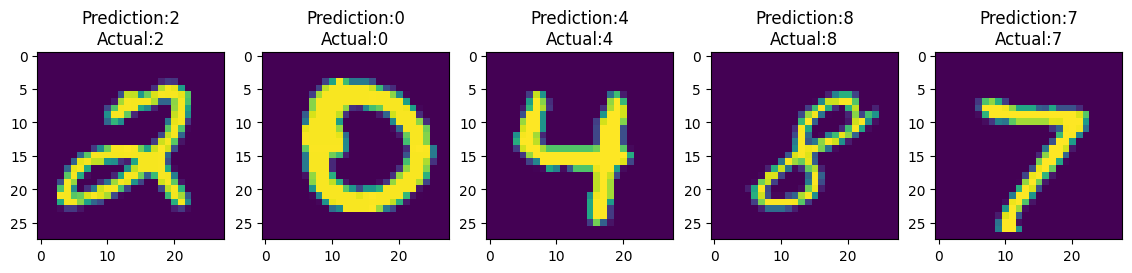

In [11]:
sample(correct=True, rows=1, cols=5)

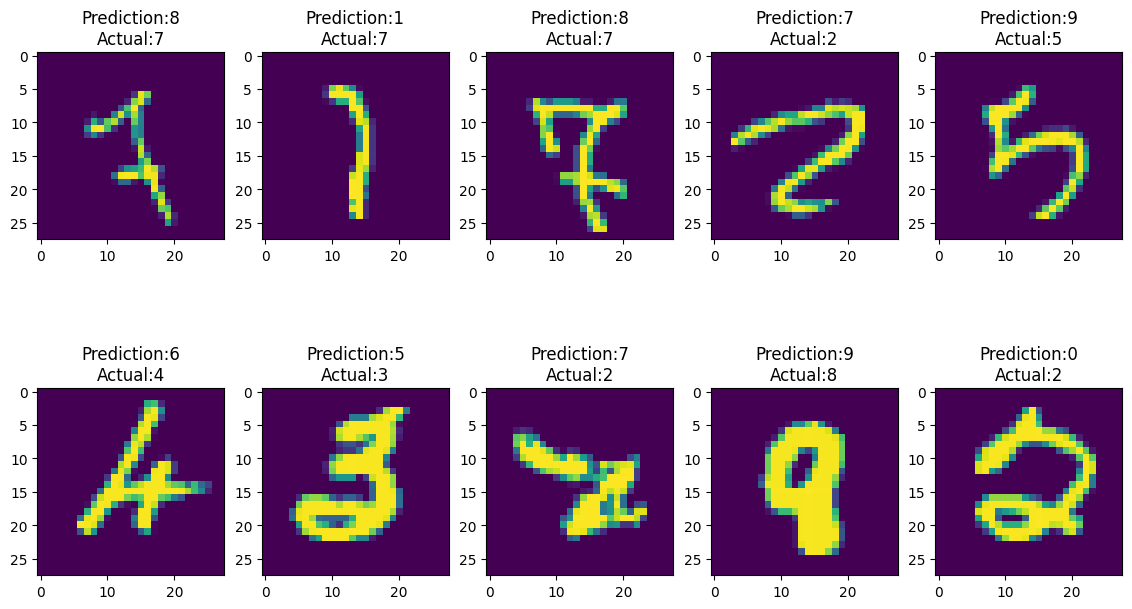

In [12]:
sample(correct=False, rows=2, cols=5)

## Save to disk as a TensorFlow SavedModel

It is very common to take a model trained using TensorFlow and save it to disk as a "saved model". This is a language independent format that allows you to load your model code using Python, C++ or other languages supported by TensorFlow.

### Saving

In order to save our model to disk, we need to define what the functions are that we want to save, and provide references to any state we want to save:

In [13]:
@tf.function(autograph=False, input_signature=[tf.TensorSpec([100, 28 * 28])])
def forward(x):
  return net(x)

to_save = tf.Module()
to_save.forward = forward
to_save.params = list(net.variables)
tf.saved_model.save(to_save, "/tmp/example_saved_model")

### Loading

Loading a saved model is trivial, and you can see that this looks a lot like the model we saved:

In [14]:
loaded = tf.saved_model.load("/tmp/example_saved_model")
preds = loaded.forward(tf.ones([100, 28 * 28]))
assert preds.shape == [100, 10]
assert len(loaded.params) == 6

[v.name for v in loaded.params]

['jax_module/mlp/_/linear_0/b:0',
 'jax_module/mlp/_/linear_0/w:0',
 'jax_module/mlp/_/linear_1/b:0',
 'jax_module/mlp/_/linear_1/w:0',
 'jax_module/mlp/_/linear_2/b:0',
 'jax_module/mlp/_/linear_2/w:0']

Thankfully the restored model performs just as well as the model that we saved:

In [15]:
accuracy(loaded.forward)

Got 9800/10000 (98.00%) correct
